In [2]:
import os
import random
import time
import torch
import torch.nn as nn
import numpy as np

from transformers import AdamW
from colbert.utils.runs import Run
from colbert.utils.amp import MixedPrecisionManager

from colbert.training.lazy_batcher import LazyBatcher
from colbert.training.eager_batcher import EagerBatcher
from colbert.parameters import DEVICE

from colbert.modeling.colbert import ColBERT
from colbert.utils.utils import print_message
from colbert.training.utils import print_progress, manage_checkpoints

query_maxlen = 512
query_maxlen = 512
doc_maxlen = 512
dim = 128
similarity = 'cosine'

colbert = ColBERT.from_pretrained('bert-base-uncased', query_maxlen=query_maxlen, doc_maxlen=doc_maxlen, dim=dim, similarity_metric=similarity, mask_punctuation=False)

2022-12-07 13:20:43.665997: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Some weights of the model checkpoint at bert-base-uncased were not used when initializing ColBERT: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing ColBERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ColBERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of

In [2]:
print(sum(p.numel() for p in colbert.parameters()))

109580544


In [3]:
colbert

ColBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

## TTM

In [23]:
import matplotlib.pyplot as plt
  

In [15]:
fc_w = colbert.bert.encoder.layer[4].intermediate.dense.weight
fc_w_new = colbert.bert.encoder.layer[4].intermediate.dense

In [16]:
fc_w.shape

torch.Size([3072, 768])

In [17]:
import tntorch as tn

In [18]:
fc_w.shape[-1]

768

In [25]:
input_dims = [16, 16, 12]
input_dims = [16, 16, 3]
ranks = [50, 50]

#ttm = tn.TTMatrix(fc_w, ranks=ranks, input_dims=input_dims, output_dims=output_dims)

[12.523158] [0.50037915]


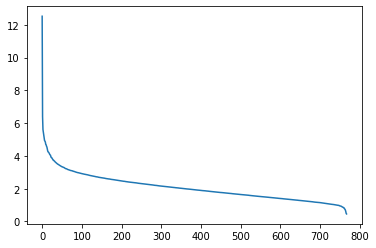

In [24]:
u,s,vh = np.linalg.svd(fc_w.cpu().detach().numpy())
plt.plot(s)
print (s[0:1], s[len(s)-2: len(s)-1])
plt.show()

In [34]:
fc_w.shape

torch.Size([3072, 768])

In [36]:
np.prod([4, 4, 8, 6])

768

In [ ]:
input_dims = [6, 8, 8, 8]
output_dims = [4, 4, 8, 6]
ranks = [50, 50]

#24, 32, 64, 48

errs5_m = []
ranks5_m = []
c_rates5_m = []

compression_rate = 0.001

err = 10.0
rank1 = 40
rank2 = 40
step = 5

while (compression_rate < 0.7):
    
    factors = tn.TTMatrix(fc_w, ranks=[rank1, rank2, rank1], input_dims=input_dims, output_dims=output_dims)
    new_B = factors.torch()
    print (fc_w.shape, new_B.shape)
    err = np.linalg.norm(new_B.detach().numpy() - fc_w.detach().numpy())/np.linalg.norm(fc_w.detach().numpy())
    print ([elem.shape for elem in factors.cores])
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.cores))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs5_m.append(err)
    ranks5_m.append(rank1)
    c_rates5_m.append(compression_rate)
    rank1 += step
    rank2 += step

In [ ]:
output_dims = [4, 6, 8, 4]
input_dims = [8, 8, 6, 8]
ranks = [50, 50]

errs1_m = []
ranks1_m = []
c_rates1_m = []

compression_rate = 0.001

err = 10.0
rank1 = 40
rank2 = 40
step = 5

while (compression_rate < 0.7):
    
    factors = tn.TTMatrix(fc_w, ranks=[rank1, rank2, rank1], input_dims=input_dims, output_dims=output_dims)
    new_B = factors.torch()
    print (fc_w.shape, new_B.shape)
    err = np.linalg.norm(new_B.detach().numpy() - fc_w.detach().numpy())/np.linalg.norm(fc_w.detach().numpy())
    print ([elem.shape for elem in factors.cores])
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.cores))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs1_m.append(err)
    ranks1_m.append(rank1)
    c_rates1_m.append(compression_rate)
    rank1 += step
    rank2 += step

torch.Size([3072, 768]) torch.Size([3072, 768])
[torch.Size([1, 8, 4, 32]), torch.Size([32, 8, 6, 40]), torch.Size([40, 6, 8, 32]), torch.Size([32, 8, 4, 1])]
err  0.9418562 compression_rate  0.05295138888888889 rank  40 40
torch.Size([3072, 768]) torch.Size([3072, 768])
[torch.Size([1, 8, 4, 32]), torch.Size([32, 8, 6, 45]), torch.Size([45, 6, 8, 32]), torch.Size([32, 8, 4, 1])]
err  0.9359917 compression_rate  0.05946180555555555 rank  45 45
torch.Size([3072, 768]) torch.Size([3072, 768])
[torch.Size([1, 8, 4, 32]), torch.Size([32, 8, 6, 50]), torch.Size([50, 6, 8, 32]), torch.Size([32, 8, 4, 1])]
err  0.9301831 compression_rate  0.06597222222222222 rank  50 50
torch.Size([3072, 768]) torch.Size([3072, 768])
[torch.Size([1, 8, 4, 32]), torch.Size([32, 8, 6, 55]), torch.Size([55, 6, 8, 32]), torch.Size([32, 8, 4, 1])]
err  0.92442006 compression_rate  0.0724826388888889 rank  55 55
torch.Size([3072, 768]) torch.Size([3072, 768])
[torch.Size([1, 8, 4, 32]), torch.Size([32, 8, 6, 60]), 

In [ ]:
fc_w.shape

In [ ]:
output_dims = [4, 6, 8, 4]
input_dims = [8, 8, 6, 8]
ranks = [50, 50]

errs1_m = []
ranks1_m = []
c_rates1_m = []

compression_rate = 0.001

err = 10.0
rank1 = 20
rank2 = 20
step = 10

while (compression_rate < 0.7):
    
    factors = tn.TTMatrix(fc_w, ranks=[rank1, rank2, rank1], input_dims=input_dims, output_dims=output_dims)
    new_B = factors.torch()
    print (fc_w.shape, new_B.shape)
    err = np.linalg.norm(new_B.detach().numpy() - fc_w.detach().numpy())/np.linalg.norm(fc_w.detach().numpy())
    print ([elem.shape for elem in factors.cores])
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.cores))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs1_m.append(err)
    ranks1_m.append(rank1)
    c_rates1_m.append(compression_rate)
    rank1 += step

In [28]:
errs3_m = []
ranks3_m = []
c_rates3_m = []

compression_rate = 0.001

err = 10.0
rank1 = 10
rank2 = 20
rank3 = 15
step = 5

B = fc_w

while (compression_rate < 0.7):    
    factors = tn.Tensor(B.reshape(24, 32, 64, 48), ranks_tt=[rank1, rank2, rank3])
    new_B = factors.torch()
    print (fc_w.shape, new_B.shape)
    err = np.linalg.norm(new_B.detach().numpy() - fc_w.detach().numpy().reshape(24, 32, 64, 48))/np.linalg.norm(fc_w.detach().numpy())
    print ([elem.shape for elem in factors.cores])
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.cores))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2, rank3)
    errs3_m.append(err)
    ranks3_m.append(rank1)
    c_rates3_m.append(compression_rate)
    #if rank2 <= rank1:
       #rank2 +=step
    #else:
    rank1 += step
    rank2 += step
    rank3 += step

torch.Size([3072, 768]) torch.Size([24, 32, 64, 48])
[torch.Size([1, 24, 10]), torch.Size([10, 32, 20]), torch.Size([20, 64, 15]), torch.Size([15, 48, 1])]
err  0.97617275 compression_rate  0.011257595486111112 rank  10 20 15
torch.Size([3072, 768]) torch.Size([24, 32, 64, 48])
[torch.Size([1, 24, 15]), torch.Size([15, 32, 25]), torch.Size([25, 64, 20]), torch.Size([20, 48, 1])]
err  0.96615803 compression_rate  0.019209120008680556 rank  15 25 20
torch.Size([3072, 768]) torch.Size([24, 32, 64, 48])
[torch.Size([1, 24, 20]), torch.Size([20, 32, 30]), torch.Size([30, 64, 25]), torch.Size([25, 48, 1])]
err  0.95295525 compression_rate  0.029195149739583332 rank  20 30 25
torch.Size([3072, 768]) torch.Size([24, 32, 64, 48])
[torch.Size([1, 24, 24]), torch.Size([24, 32, 35]), torch.Size([35, 64, 30]), torch.Size([30, 48, 1])]
err  0.93770576 compression_rate  0.040730794270833336 rank  25 35 30
torch.Size([3072, 768]) torch.Size([24, 32, 64, 48])
[torch.Size([1, 24, 24]), torch.Size([24, 3

In [29]:
errs2_m = []
ranks2_m = []
c_rates2_m = []

compression_rate = 0.001

err = 10.0
rank1 = 50
rank2 = 50
step = 10

B = fc_w

while (compression_rate < 0.7):    
    factors = tn.Tensor(B.reshape(32, 48, 48, 32), ranks_tt=[rank1, rank1, rank1])
    new_B = factors.torch()
    print (fc_w.shape, new_B.shape)
    err = np.linalg.norm(new_B.detach().numpy() - fc_w.detach().numpy().reshape(32, 48, 48, 32))/np.linalg.norm(fc_w.detach().numpy())
    print ([elem.shape for elem in factors.cores])
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.cores))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs2_m.append(err)
    ranks2_m.append(rank1)
    c_rates2_m.append(compression_rate)
    #if rank2 <= rank1:
       #rank2 +=step
    #else:
    rank1 += step

torch.Size([3072, 768]) torch.Size([32, 48, 48, 32])
[torch.Size([1, 32, 32]), torch.Size([32, 48, 50]), torch.Size([50, 48, 32]), torch.Size([32, 32, 1])]
err  0.89188683 compression_rate  0.06597222222222222 rank  50 50
torch.Size([3072, 768]) torch.Size([32, 48, 48, 32])
[torch.Size([1, 32, 32]), torch.Size([32, 48, 60]), torch.Size([60, 48, 32]), torch.Size([32, 32, 1])]
err  0.87817097 compression_rate  0.07899305555555555 rank  60 50
torch.Size([3072, 768]) torch.Size([32, 48, 48, 32])
[torch.Size([1, 32, 32]), torch.Size([32, 48, 70]), torch.Size([70, 48, 32]), torch.Size([32, 32, 1])]
err  0.8649511 compression_rate  0.0920138888888889 rank  70 50
torch.Size([3072, 768]) torch.Size([32, 48, 48, 32])
[torch.Size([1, 32, 32]), torch.Size([32, 48, 80]), torch.Size([80, 48, 32]), torch.Size([32, 32, 1])]
err  0.85215884 compression_rate  0.10503472222222222 rank  80 50
torch.Size([3072, 768]) torch.Size([32, 48, 48, 32])
[torch.Size([1, 32, 32]), torch.Size([32, 48, 90]), torch.Siz

In [44]:
len(c_rates3_m)

83

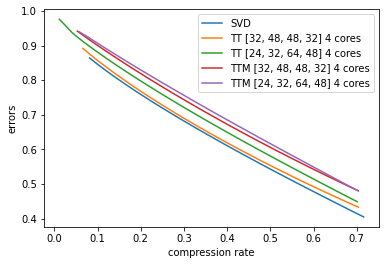

In [47]:
import matplotlib.pyplot as plt
  
24, 32, 64, 48
# plot lines
plt.plot(c_rates, errs, label = "SVD")
plt.plot(c_rates2_m, errs2_m,  label = "TT [32, 48, 48, 32] 4 cores ")
plt.plot(c_rates3_m, errs3_m,  label = "TT [24, 32, 64, 48] 4 cores ")
plt.plot(c_rates1_m, errs1_m,  label = "TTM [32, 48, 48, 32] 4 cores")
plt.plot(c_rates5_m, errs5_m,  label = "TTM [24, 32, 64, 48] 4 cores")
#plt.plot(errs1_m, c_rates1_m, label = "TTM (permute + reshape)")
plt.ylabel('errors')
plt.xlabel('compression rate')
plt.legend()
plt.show()

In [30]:
errs = []
ranks = []
c_rates = []

err = 10.0
rank = 50
compression_rate = 0.0

step = 10
while (compression_rate < 0.7):
    U, S, Vt = np.linalg.svd(fc_w.detach().numpy(), full_matrices=False)
    # truncate SVD and fuse Sigma matrix
    w1 = np.dot(np.diag(np.sqrt(S[0:rank])),Vt[0:rank, :])
    w2 = np.dot(U[:, 0:rank], np.diag(np.sqrt(S[0:rank])))
    fc_rec = np.dot(w2, w1)
    err = np.linalg.norm(fc_rec - fc_w.data.numpy())/np.linalg.norm(fc_w.data.numpy())
    compression_rate = (np.prod(w1.shape) + np.prod(w2.shape))/((np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank)
    errs.append(err)
    ranks.append(rank)
    c_rates.append(compression_rate)
    rank += step

err  0.86423 compression_rate  0.08138020833333333 rank  50
err  0.8481262 compression_rate  0.09765625 rank  60
err  0.83279854 compression_rate  0.11393229166666667 rank  70
err  0.8180031 compression_rate  0.13020833333333334 rank  80
err  0.8036815 compression_rate  0.146484375 rank  90
err  0.7897288 compression_rate  0.16276041666666666 rank  100
err  0.7760865 compression_rate  0.17903645833333334 rank  110
err  0.76269233 compression_rate  0.1953125 rank  120
err  0.74958867 compression_rate  0.21158854166666666 rank  130
err  0.7367368 compression_rate  0.22786458333333334 rank  140
err  0.7241182 compression_rate  0.244140625 rank  150
err  0.71165377 compression_rate  0.2604166666666667 rank  160
err  0.6993818 compression_rate  0.2766927083333333 rank  170
err  0.6872489 compression_rate  0.29296875 rank  180
err  0.67526895 compression_rate  0.3092447916666667 rank  190
err  0.6634542 compression_rate  0.3255208333333333 rank  200
err  0.6517644 compression_rate  0.3417968

In [7]:
t = tn.Tensor(fc_w.reshape(32, 48, 48, 32), ranks_tt=[380, 390, 380])  # You can also pass a list of ranks

full =fc_w.reshape(32, 48, 48, 32)

def metrics():
    print(t)
    print('Compression ratio: {}/{} = {:g}'.format(full.numel(), t.numel(), full.numel() / t.numel()))
    print('Relative error:', tn.relative_error(full, t))
    print('RMSE:', tn.rmse(full, t))
    print('R^2:', tn.r_squared(full, t))

metrics()


4D TT tensor:

 32  48  48  32
  |   |   |   |
 (0) (1) (2) (3)
 / \ / \ / \ / \
1   32  390 32  1

Compression ratio: 2359296/2359296.0 = 1
Relative error: tensor(0.5481, grad_fn=<DivBackward0>)
RMSE: tensor(0.0223, grad_fn=<DivBackward0>)
R^2: tensor(0.6996, grad_fn=<RsubBackward1>)


In [16]:
fc_w.shape[1],fc_w.shape[0]

(768, 3072)

## TT

In [ ]:
from tensorly.tt_matrix import TTMatrix
import tntorch

errs1_m = []
ranks1_m = []
c_rates1_m = []

err = 10.0
rank1 = 30
rank2 = 30
step = 5

B = fc_w
B = fc_w.reshape([128, 192, 96]) # B = B.reshape((8, 12, 8, 16, 12, 16))


while (err > 0.1):
    factors = tntorch.Tensor(B, ranks_tt = [rank1, rank2])
    for i,f in enumerate(factors.cores):
        print ("initial", f.shape)
    restore = tntorch.Tensor(factors.cores).torch()
    err = torch.norm(restore - B)/torch.norm(B)
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.cores))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs1_m.append(err)
    ranks1_m.append(rank1)
    c_rates1_m.append(compression_rate)
    if (rank1 > rank2):
        rank2 += step
    else:
        rank1 += step

In [29]:
fc_w.shape

torch.Size([3072, 768])

In [34]:
2x4x8x4x2 input modes and 4x4x8x4x4 512 1024
2x4x8x4x2 input modes and 12x4x8x4x2 512 3072

SyntaxError: invalid syntax (<ipython-input-34-9df16eea0675>, line 1)

In [ ]:
errs7 = []
ranks7 = []
c_rates7 = []

err = 10.0
rank1 = 10
rank2 = 10
step = 4
compression_rate = 0.0

import tensorly as tl
from tensorly.decomposition import tensor_train
tl.set_backend('pytorch')

B = fc_w
B = fc_w.reshape((32, 48, 48, 32)) 
B = fc_w.reshape((4, 4, 8, 12, 12 ,8, 4,4)) 


while (compression_rate < 0.7):
    
    factors = tensor_train(B, rank = [1, rank1, rank1, rank1, rank1, rank1, rank1, rank1, 1])
    new_B = factors.to_tensor()
    print (B.shape, new_B.shape)
    err = np.linalg.norm(new_B.detach().numpy() - B.detach().numpy())/np.linalg.norm(B.detach().numpy())
    print ([elem.shape for elem in factors.factors])
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.factors))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs7.append(err)
    ranks7.append(rank1)
    c_rates7.append(compression_rate)
    rank1 += step
    

In [ ]:
errs8 = []
ranks8 = []
c_rates8 = []

err = 10.0
rank1 = 10
rank2 = 10
step = 4
compression_rate = 0.0

import tensorly as tl
from tensorly.decomposition import tensor_train
tl.set_backend('pytorch')

B = fc_w
B = fc_w.reshape((32, 48, 48, 32)) 
# 10 (2, 4, 4, 4, 6, 12, 8, 4, 4, 2)
(4, 4, 8, 12, 12 ,8, 4,4)
B = fc_w.reshape((2, 2, 2, 2, 4, 2, 3, 4, 3, 4, 4, 2, 2, 2, 2, 2)) 


while (compression_rate < 0.7):
    
    factors = tensor_train_matrix1(B, rank = [1, rank1, rank1, rank1, rank1, rank1, rank1, rank1, 1])
    new_B = factors.to_tensor()
    #print (B.shape, new_B.shape)
    err = np.linalg.norm(new_B.detach().numpy() - B.detach().numpy())/np.linalg.norm(B.detach().numpy())
    #print ([elem.shape for elem in factors.factors])
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.factors))/(np.prod(fc_w.shape)))
    #print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs8.append(err)
    ranks8.append(rank1)
    c_rates8.append(compression_rate)
    rank1 += step

In [ ]:
factors = tensor_train_matrix1(B, rank = [1, rank1, rank2, rank1, rank2, 1])
new_B = factors.to_tensor()

In [34]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'f', 'step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
import matplotlib.pyplot as plt
  

# 10 cores [2, 4, 4, 4, 6, 12, 8, 4, 4, 2]    
# plot lines
plt.plot(c_rates, errs, label = "SVD")
#plt.plot(c_rates8, errs8, label = "TTM 8 cores")
plt.plot(c_rates7, errs7,  label = "TT 8 cores ")
#plt.plot(c_rates3, errs3,  label = "TTM 8 cores")
plt.plot(c_rates3_m, errs3_m,  label = "TT 4 cores")
plt.plot(c_rates4_m, errs4_m,  label = "TT 10 cores")
plt.plot(c_rates1_m, errs1_m,  label = "TT 3 core")
#plt.plot(errs1_m, c_rates1_m, label = "TTM (permute + reshape)")
plt.ylabel('errors')
plt.xlabel('compression rate')
plt.legend()
plt.show()

In [58]:
errs3_m

[]

In [ ]:
errs4_m = []
ranks4_m = []
c_rates4_m = []

err = 10.0
rank1 = 10
rank2 = 10
step = 6

B = fc_w

#B = B.reshape(32, 48, 48, 32)
#B = B.reshape(64, 64, 24, 24)
#B = B.reshape((8, 4, 8, 6, 8, 6, 8, 4))
print (B.shape)
B = B.reshape((2, 4, 4, 4, 8, 12, 6, 4, 4, 2))
print (B.shape)


while (err > 0.1):
    factors = tensor_train(B, rank = [1, rank1, rank1, rank1, rank2, rank2, rank2, rank1, rank1, rank1, 1])
    new_B = factors.to_tensor()
    print (B.shape, new_B.shape)
    err = np.linalg.norm(new_B.detach().numpy() - B.detach().numpy())/np.linalg.norm(B.detach().numpy())
    print ([elem.shape for elem in factors.factors])
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.factors))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs4_m.append(err)
    ranks4_m.append(rank1)
    c_rates4_m.append(compression_rate)
    if (rank1 > rank2):
        rank2 += step
    else:
        rank1 += step

In [15]:
import tensorly as tl
from tensorly.decomposition import tensor_train
tl.set_backend('pytorch')

errs2 = []
ranks2 = []
c_rates2 = []

err = 10.0
rank1 = 60
rank2 = 60
step = 10
compression_rate = 0.0

B = fc_w
B = B.reshape(32, 48, 48, 32)
B = B.reshape(4, 8, 6, 8, 6, 8, 4, 8)
#B = B.permute(0, 2, 4, 1, 3, 5)

while (compression_rate < 0.7):
    
    factors = tntorch.Tensor(B, ranks_tt = [rank1, rank2])
    for i,f in enumerate(factors.cores):
        print ("initial", f.shape)
    restore = tntorch.Tensor(factors.cores).torch()
    err = torch.norm(restore - B)/torch.norm(B)
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.cores))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs2.append(err)
    ranks2.append(rank1)
    c_rates2.append(compression_rate)
    if (rank1 < rank2):
        rank1 += step
    else:
        rank2 += step

AssertionError: 

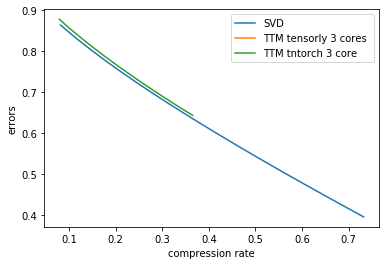

In [64]:
import matplotlib.pyplot as plt
  

# plot lines
plt.plot(c_rates, errs, label = "SVD")
plt.plot(c_rates2, errs2,  label = "TTM tensorly 3 cores ")
plt.plot(c_rates3_m, errs3_m,  label = "TTM tntorch 3 core")
#plt.plot(errs1_m, c_rates1_m, label = "TTM (permute + reshape)")
plt.ylabel('errors')
plt.xlabel('compression rate')
plt.legend()
plt.show()

In [ ]:
import tensorly as tl
from tensorly.decomposition import tensor_train
tl.set_backend('pytorch')


B = fc_w
B = B = B.reshape((8, 12, 8, 16, 12, 16))


errs3 = []
ranks3 = []
c_rates3 = []

err = 10.0
rank1 = 20
rank2 = 20
step = 10
compression_rate = 0.0
while (compression_rate < 0.7):
    factors = tensor_train_matrix1(B, rank = [1, rank1, rank2, 1])
    new_B = factors.to_tensor()
    print (B.shape, new_B.shape)
    err = np.linalg.norm(new_B.detach().numpy() - B.detach().numpy())/np.linalg.norm(B.detach().numpy())
    print ([elem.shape for elem in factors.factors])
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.factors))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs3.append(err)
    ranks3.append(rank1)
    c_rates3.append(compression_rate)
    if (rank1 < rank2):
        rank1 += step
    else:
        rank2 += step

In [28]:
import tensorly as tl
from tensorly.decomposition import tensor_train
tl.set_backend('pytorch')

from src.ttm_linear.ttm_linear.ttm_linear import FactorizationTTMLinear, prepare_core_shapes


errs4 = []
ranks4 = []
c_rates4 = []

err = 10.0
rank1 = 20
rank2 = 20
step = 10
compression_rate = 0.0
while (compression_rate < 0.7):
    #B = B.reshape((24, 16, 16, 16, 24))
    factors = tensor_train_matrix2(B, rank = [1, rank1, rank2, rank1, rank2, 1], rank1 = rank1, rank2 = rank2)
    new_B = tntorch.Tensor(factors.cores).torch()
    print (B.shape, new_B.shape)
    err = np.linalg.norm(new_B.detach().numpy() - B.detach().numpy())/np.linalg.norm(B.detach().numpy())
    print ([elem.shape for elem in factors.factors])
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.factors))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs4.append(err)
    ranks4.append(rank1)
    c_rates4.append(compression_rate)
    if (rank1 < rank2):
        rank1 += step
    else:
        rank2 += step

torch.Size([6, 4, 4, 4, 4, 4, 4, 4, 4, 6])
10
new_shape [24, 16, 16, 16, 24]


AttributeError: 'Tensor' object has no attribute 'reshape'

In [12]:
B.shape

torch.Size([24, 16, 16, 16, 24])

In [ ]:
import tensorly as tl
from tensorly.decomposition import tensor_train
tl.set_backend('pytorch')

errs2 = []
ranks2 = []
c_rates2 = []

err = 10.0
rank1 = 60
rank2 = 60
step = 10
compression_rate = 0.0

B = fc_w.reshape((32, 48, 48, 32))

while (compression_rate < 0.7):
    #B = B.reshape((8, 12, 8, 16, 12, 16))
    factors = tensor_train(B, rank = [1, rank1, rank2, rank1, 1])
    new_B = factors.to_tensor()
    print (B.shape, new_B.shape)
    err = np.linalg.norm(new_B.detach().numpy() - B.detach().numpy())/np.linalg.norm(B.detach().numpy())
    print ([elem.shape for elem in factors.factors])
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.factors))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs2.append(err)
    ranks2.append(rank1)
    c_rates2.append(compression_rate)
    if (rank1 < rank2):
        rank1 += step
    else:
        rank2 += step

In [11]:
!pip3 install tensorly

     |████████████████████████████████| 198 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 154 kB 15.4 MB/s eta 0:00:01
You should consider upgrading via the '/opt/.pyenv/versions/3.8.10/bin/python3.8 -m pip install --upgrade pip' command.


In [ ]:
import tensorly as tl
from tensorly.decomposition import tensor_train
tl.set_backend('pytorch')

errs1 = []
ranks1 = []
c_rates1 = []

err = 10.0
rank1 = 30
rank2 = 30
step = 10
compression_rate = 0.0
while (compression_rate < 0.7):
    factors = tensor_train_matrix1(B, rank = [1, rank1, rank2, 1])
    new_B = factors.to_tensor()
    err = np.linalg.norm(new_B - B)/np.linalg.norm(B)
    print ([elem.shape for elem in factors.factors])
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.factors))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs1.append(err)
    ranks1.append(rank1)
    c_rates1.append(compression_rate)
    if (rank1 < rank2):
        rank1 += step
    else:
        rank2 += step

In [5]:
np.prod(fc_w.shape)

2359296

In [147]:
D_rest = tl.tt_tensor.tt_to_tensor(factors)
err = np.linalg.norm(D_rest - D)/np.linalg.norm(D)
err

0.81661785

## reshape

In [13]:
B = fc_w.reshape((4, 4, 4, 4, 4, 4, 4, 4, 12, 3))

In [66]:
#B = fc_w.reshape((4, 4, 4, 4, 4, 4, 4, 4, 12, 3))
#B = fc_w.reshape((4, 12, 4, 12, 4, 8, 4, 8))
B = fc_w.reshape((16, 16, 12, 16, 16, 3))
B = fc_w.reshape((8, 12, 8, 16, 12, 16))

B = fc_w.reshape((32, 48, 48, 32))

In [8]:
(16, 8, 16, 12, 12, 8)

(16, 8, 16, 12, 12, 8)

In [9]:
#C = B.permute((0, 2, 4, 1, 3, 5))
C = B.permute((0, 3, 1, 4, 2, 5))
#C = B.permute((0, 5, 1, 6, 2, 7, 3, 8, 4, 9))
#C = B.permute((0, 1, 2, 3, 4))

In [10]:
print (C.shape)

torch.Size([8, 16, 12, 12, 8, 16])


In [19]:
#D = C.reshape((16, 32, 16, 16, 18))
D = C.reshape((128, 192, 96))

In [12]:
!pip3 install tntorch

You should consider upgrading via the 'pip install --upgrade pip' command.


In [15]:
factors = ttm_for_tensor(D, rank = [1, 90, 90, 90, 1])

NameError: name 'ttm_for_tensor' is not defined

In [16]:
import tntorch
from tntorch import Tensor

In [20]:
tt = tntorch.Tensor(D, ranks_tt = [90, 90])

In [23]:
for elem in tt.cores:
    print (elem.shape)

torch.Size([1, 128, 90])
torch.Size([90, 192, 90])
torch.Size([90, 96, 1])


In [24]:
restore = tntorch.Tensor(tt.cores).torch()

In [25]:
restore.shape

torch.Size([128, 192, 96])

In [56]:
B.shape

torch.Size([32, 48, 48, 32])

In [30]:
err = torch.norm(restore - D)/torch.norm(D)
err

tensor(0.5429, grad_fn=<DivBackward0>)

In [ ]:
errs5_m = []
ranks5_m = []
c_rates5_m = []

err = 10.0
rank1 = 10
rank2 = 10
step = 10
while (err > 0.1):
    factors = tntorch.Tensor(B, ranks_tt = [rank1, rank2])
    for i,f in enumerate(factors.cores):
        print ("initial", f.shape)
    restore = tntorch.Tensor(factors.cores).torch()
    err = torch.norm(restore - B)/torch.norm(B)
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.cores))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs5_m.append(err)
    ranks5_m.append(rank1)
    c_rates5_m.append(compression_rate)
    if (rank1 > rank2):
        rank2 += step
    else:
        rank1 += step

In [ ]:
errs4_m = []
ranks4_m = []
c_rates4_m = []

err = 10.0
rank1 = 10
rank2 = 10
step = 10
while (err > 0.1):
    factors = tntorch.Tensor(B, ranks_tt = [rank1, rank2, rank1])
    for i,f in enumerate(factors.cores):
        print ("initial", f.shape)
    restore = tntorch.Tensor(factors.cores).torch()
    err = torch.norm(restore - B)/torch.norm(B)
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors.cores))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs4_m.append(err)
    ranks4_m.append(rank1)
    c_rates4_m.append(compression_rate)
    if (rank1 > rank2):
        rank2 += step
    else:
        rank1 += step

In [ ]:
import tensorly as tl
from tensorly.decomposition import tensor_train
tl.set_backend('pytorch')

errs1_m = []
ranks1_m = []
c_rates1_m = []

err = 10.0
rank1 = 50
rank2 = 50
step = 4
while (err > 0.1):
    factors = ttm_for_tensor(D, rank = [1, rank1, rank2, 1])
    for i,f in enumerate(factors):
        print ("initial", f.shape)
    D_rest = tl.tt_tensor.tt_to_tensor(factors)
    err = np.linalg.norm(D_rest - D)/np.linalg.norm(D)
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs1_m.append(err)
    ranks1_m.append(rank1)
    c_rates1_m.append(compression_rate)
    if (rank1 > rank2):
        rank2 += step
    else:
        rank1 += step

In [51]:
import tensorly as tl
from tensorly.decomposition import tensor_train
tl.set_backend('pytorch')

errs1_m = []
ranks1_m = []
c_rates1_m = []

err = 10.0
rank1 = 50
rank2 = 50
step = 4
while (err > 0.1):
    factors = ttm_for_tensor(D, rank = [1, rank1, rank2, 1])
    for i,f in enumerate(factors):
        print ("initial", f.shape)
    D_rest = tl.tt_tensor.tt_to_tensor(factors)
    err = np.linalg.norm(D_rest - D)/np.linalg.norm(D)
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs1_m.append(err)
    ranks1_m.append(rank1)
    c_rates1_m.append(compression_rate)
    if (rank1 > rank2):
        rank2 += step
    else:
        rank1 += step

torch.Size([128, 192, 96])


RuntimeError: number of dims don't match in permute

In [49]:
import tensorly as tl
from tensorly.decomposition import tensor_train
tl.set_backend('pytorch')

errs1 = []
ranks1 = []
c_rates1 = []

err = 10.0
rank1 = 50
rank2 = 50
step = 2
while (compression_rate < 0.7):
    factors = ttm_for_tensor(B, rank = [1, rank1, rank2, 1])
    for i,f in enumerate(factors):
        print ("initial", f.shape)
    D_rest = tl.tt_tensor.tt_to_tensor(factors)
    err = np.linalg.norm(D_rest - B)/np.linalg.norm(B)
    compression_rate = (np.sum(list(np.prod(elem.shape) for elem in factors))/(np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank1, rank2)
    errs1.append(err)
    ranks1.append(rank1)
    c_rates1.append(compression_rate)
    if (rank1 > rank2):
        rank2 += step
    else:
        rank1 += step

NameError: name 'ttm_for_tensor' is not defined

In [15]:
errs = []
ranks = []
c_rates = []

err = 10.0
rank = 50
compression_rate = 0.0

step = 20
while (compression_rate < 0.7):
    U, S, Vt = np.linalg.svd(fc_w.detach().numpy(), full_matrices=False)
    # truncate SVD and fuse Sigma matrix
    w1 = np.dot(np.diag(np.sqrt(S[0:rank])),Vt[0:rank, :])
    w2 = np.dot(U[:, 0:rank], np.diag(np.sqrt(S[0:rank])))
    fc_rec = np.dot(w2, w1)
    err = np.linalg.norm(fc_rec - fc_w.data.numpy())/np.linalg.norm(fc_w.data.numpy())
    compression_rate = (np.prod(w1.shape) + np.prod(w2.shape))/((np.prod(fc_w.shape)))
    print ("err ", err, "compression_rate ", compression_rate, "rank ", rank)
    errs.append(err)
    ranks.append(rank)
    c_rates.append(compression_rate)
    rank += step

err  0.86423 compression_rate  0.08138020833333333 rank  50
err  0.83279854 compression_rate  0.11393229166666667 rank  70
err  0.8036815 compression_rate  0.146484375 rank  90
err  0.7760865 compression_rate  0.17903645833333334 rank  110
err  0.74958867 compression_rate  0.21158854166666666 rank  130
err  0.7241182 compression_rate  0.244140625 rank  150
err  0.6993818 compression_rate  0.2766927083333333 rank  170
err  0.67526895 compression_rate  0.3092447916666667 rank  190
err  0.6517644 compression_rate  0.341796875 rank  210
err  0.6287239 compression_rate  0.3743489583333333 rank  230
err  0.60605574 compression_rate  0.4069010416666667 rank  250
err  0.5838191 compression_rate  0.439453125 rank  270
err  0.56185037 compression_rate  0.4720052083333333 rank  290
err  0.5402275 compression_rate  0.5045572916666666 rank  310
err  0.5188214 compression_rate  0.537109375 rank  330
err  0.49768755 compression_rate  0.5696614583333334 rank  350
err  0.47678825 compression_rate  0.60

In [49]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['step', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


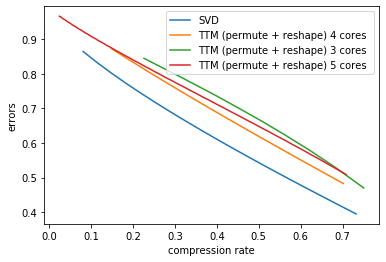

In [27]:
import matplotlib.pyplot as plt
  

# plot lines
plt.plot(c_rates, errs, label = "SVD")
plt.plot(c_rates1, errs1,  label = "TTM (permute + reshape) 4 cores ")
plt.plot(c_rates2, errs2,  label = "TTM (permute + reshape) 3 cores ")
plt.plot(c_rates3, errs3,  label = "TTM (permute + reshape) 5 cores ")
#plt.plot(errs1_m, c_rates1_m, label = "TTM (permute + reshape)")
plt.ylabel('errors')
plt.xlabel('compression rate')
plt.savefig('Different approaches to compression.png')
plt.legend()
plt.show()

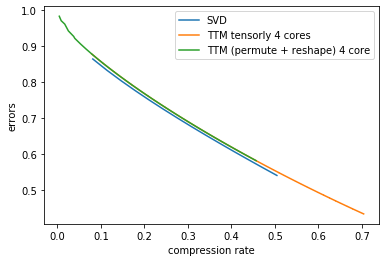

In [71]:
import matplotlib.pyplot as plt
  

# plot lines
plt.plot(c_rates, errs, label = "SVD")
plt.plot(c_rates2, errs2,  label = "TTM tensorly 4 cores ")
plt.plot(c_rates4_m, errs4_m,  label = "TTM (permute + reshape) 4 core")
#plt.plot(errs1_m, c_rates1_m, label = "TTM (permute + reshape)")
plt.ylabel('errors')
plt.xlabel('compression rate')
plt.legend()
plt.show()

In [51]:
list(np.prod(elem.shape) for elem in new_factors)

[12800, 120000, 9600]

In [48]:
print (np.sum(list(np.prod(elem.shape) for elem in new_factors))/(3072*768))

0.03475613064236111
